# Reaction-uniprot data clean up

In [158]:
%load_ext autoreload
%autoreload 2
from src.utils import load_json, save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges
import pandas as pd
import csv
from collections import defaultdict
from collections import namedtuple, Counter
from rdkit import Chem
import numpy as np

In [159]:
def extract_info(entry):
    # Pull entry and uniprot ids
    if len(entry) == 3:
        rdict, pdict, uniprot = entry
        
        if uniprot == '':
            uniprot = []
        else:
            uniprot = uniprot.split(',')

    elif len(entry) == 2:
        rdict, pdict = entry
        uniprot = []

    # Smiles
    reactants, products = list(rdict.values()), list(pdict.values())
    reactants, products = sanitize(reactants, products)
    reactants, products = neutralize(reactants, products)
    sma = ".".join(sorted(reactants)) + ">>" + ".".join(sorted(products)) # Sort for consistent ordering of subs

    # Inchi (smiles if pathological) hashes
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    
    return rhash, uniprot, sma
    
def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

In [160]:
# Add info from JNI's "uniprot" jsons

brenda_uniprot = load_json('../data/mapping/brenda_uniprot.json')
mc_uniprot = load_json('../data/mapping/metacyc_uniprot.json')
combo_dataset = defaultdict(lambda : defaultdict(lambda : {'smarts':None, 'uniprot_ids':[]}))
bad_reactions = []

# Add metacyc first
for reaction_key, reaction_entry in mc_uniprot.items():
    rhash, uniprot_ids, smarts = extract_info(reaction_entry)
    combo_dataset[rhash][f"metacyc:{reaction_key}"]['uniprot_ids'] = uniprot_ids
    combo_dataset[rhash][f"metacyc:{reaction_key}"]['smarts'] = smarts

# Add brenda. There are multiple reactions per entry
# so we have to iterate through them all
for k, v in brenda_uniprot.items():
    n_reactions = len(v)
    n_digits = np.log10(n_reactions).astype(int) + 1

    for i in range(n_reactions):
        reaction_key = f"{k}_{i:0{n_digits}}"
        reaction_entry = v[i]
        rhash, uniprot_ids, smarts = extract_info(reaction_entry)
        combo_dataset[rhash][f"brenda:{reaction_key}"]['uniprot_ids'] = uniprot_ids
        combo_dataset[rhash][f"brenda:{reaction_key}"]['smarts'] = smarts

[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:49] Explicit valence for atom # 26 O, 3, is greater than permitted
[10:31:50] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:50] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 25 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 25 N, 4, is greater than permitted
[10:31:51] Explicit valence for atom # 16 

In [ ]:
# Merge in JNI's reaction jsons

db_names = ["mc_v21", "brenda", "kegg"]
mc_rxns, brenda_rxns, kegg_rxns = [load_json(f"../data/mapping/{elt}_as_is.json") for elt in db_names]
db_new_names_to_rxns = {"metacyc":mc_rxns, "brenda":brenda_rxns, "kegg":kegg_rxns}

for new_name, rxns in db_new_names_to_rxns.items():
    for reaction_key, reaction_entry in rxns.items():
        rhash, uniprot_ids, smarts = extract_info(reaction_entry)
        if rhash not in combo_dataset:
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['uniprot_ids'] = uniprot_ids
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['smarts'] = smarts
        elif f"{new_name}:{reaction_key}" not in combo_dataset[rhash]:
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['uniprot_ids'] = uniprot_ids
            combo_dataset[rhash][f"{new_name}:{reaction_key}"]['smarts'] = smarts

[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:38] Explicit valence for atom # 26 O, 3, is greater than permitted
[01:11:39] Explicit valence for atom # 16 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 16 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:40] Explicit valence for atom # 9 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 16 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 25 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 25 N, 4, is greater than permitted
[01:11:41] Explicit valence for atom # 16 

In [ ]:
# Add in mapped rules
df_opt = pd.read_csv('../data/mapping/intermediate_rules_optimized_rxns.tsv', sep='\t')
db_ids_to_rules = defaultdict(list)
rules_to_db_ids = defaultdict(list)
nrxns = 0
for index, row in df_opt.iterrows():
    rule = row["Name"]
    db_ids = row["Comments"].split(';')
    nrxns += len(db_ids)
    for elt in db_ids:
        db_ids_to_rules[elt].append(rule)

for rhash, entry in combo_dataset.items():
    for db_id in entry.keys():
        entry[db_id]['imt_rules'] = db_ids_to_rules.get(db_id, [])

In [ ]:
ct_combo = 0
degen = []
for k,v in combo_dataset.items():
    degen.append(len(v))
    for db_id in v.keys():
        ct_combo += 1

print(ct_combo)
print(sum(degen) / len(degen))

map_ct = 0
for k,v in db_ids_to_rules.items():
    if len(v) > 0:
        map_ct += 1

print(map_ct)
print(len(combo_dataset))

91034
1.773539324748193
65819
51329


In [ ]:
save_json(combo_dataset , "../data/mapping/known_rxns_w_provenance_all_info_jni.json")

# collapse multiple db entries both with and without provenance for uniprot ids

In [ ]:
%load_ext autoreload
%autoreload 2
from src.utils import load_json, save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges
import pandas as pd
import csv
from collections import defaultdict
from collections import namedtuple, Counter
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
combo_dataset = load_json("../data/mapping/known_rxns_w_provenance_all_info_jni.json")

In [ ]:
'''
Combine multiple db entries under single rhash
i.e., combine their imt_rules, smarts into one.

In rare cases where inconsistent smarts, rules
or both under single rhash (<1% due mainly to tautomeric
differences not captured when I hash first inchi segment),
take subset of db entries with imt rules, then take most common
SMARTS / tautomer form. Bring all uniprot ids along
''' 
folded_dataset = defaultdict(lambda : {'smarts':None, 'imt_rules':None, 'uniprot_ids':None})


# Get problem entries
bad_smarts = set()
bad_rules = set()

for rhash, entry in combo_dataset.items():
    for i, db_entry in enumerate(entry.values()):
        if i == 0:
            first_smarts = db_entry['smarts']
            first_rules = db_entry['imt_rules']

        elif first_smarts != db_entry['smarts']:
            bad_smarts.add(rhash)

        elif first_rules != db_entry['imt_rules']:
            bad_rules.add(rhash)

print(len(bad_smarts))
print(len(bad_rules))
print(len(combo_dataset))

bad_db_entries = bad_smarts | bad_rules


for rhash, entry in combo_dataset.items():
    if rhash not in bad_db_entries:
        uids = {}
        for i, (db_id, db_entry) in enumerate(entry.items()):
            if i == 0:
                folded_dataset[rhash]['smarts'] = db_entry['smarts']
                folded_dataset[rhash]['imt_rules'] = db_entry['imt_rules']

            if len(db_entry['uniprot_ids']) > 0:
                uids[db_id] = db_entry['uniprot_ids']

        folded_dataset[rhash]['uniprot_ids'] = uids

    elif any([len(v['imt_rules']) > 0 for v in entry.values()]):
        with_rules = [v['smarts'] for v in entry.values() if len(v['imt_rules'])]
        top_smarts = sorted(Counter(with_rules).items(), key=lambda x: x[1])[0][0]
        
        rules = []
        for v in entry.values():
            if v['smarts'] == top_smarts:
                rules += v['imt_rules']

        uids = {k: v['uniprot_ids'] for k,v in entry.items()}

        folded_dataset[rhash]['smarts'] = top_smarts
        folded_dataset[rhash]['imt_rules'] = rules
        folded_dataset[rhash]['uniprot_ids'] = uids
    
    else:
        with_rules = [v['smarts'] for v in entry.values()]
        top_smarts = sorted(Counter(with_rules).items(), key=lambda x: x[1])[0][0]
        
        rules = []
        for v in entry.values():
            if v['smarts'] == top_smarts:
                rules += v['imt_rules']

        uids = {k: v['uniprot_ids'] for k,v in entry.items()}

        folded_dataset[rhash]['smarts'] = top_smarts
        folded_dataset[rhash]['imt_rules'] = rules
        folded_dataset[rhash]['uniprot_ids'] = uids

491
422
51329


In [ ]:
# Check at least that you put something in every entry

for k,v in folded_dataset.items():
    try:
        assert type(v['smarts']) == str
        assert type(v['imt_rules']) == list
        assert type(v['uniprot_ids']) == dict
    except:
        print(k)


    for db_id, unis in v['uniprot_ids'].items():
        try:
            assert type(unis) == list
        except:
            print(k)

In [ ]:
save_json(folded_dataset , "../data/mapping/known_rxns_w_uniprot_provenance_jni.json")

In [ ]:
'''
Finally, club all uniprot ids into one set
per reaction entry
'''

folded_dataset = load_json("../data/mapping/known_rxns_w_uniprot_provenance_jni.json")

no_provenance = defaultdict(lambda : {'smarts':None, 'imt_rules':None, 'uniprot_ids':None})
for rhash, entry in folded_dataset.items():
    uids = set()
    for uilist in entry['uniprot_ids'].values():
        for elt in uilist:
            uids.add(elt)

    uids = list(uids)

    no_provenance[rhash]['smarts'] = folded_dataset[rhash]['smarts']
    no_provenance[rhash]['imt_rules'] = folded_dataset[rhash]['imt_rules']
    no_provenance[rhash]['uniprot_ids'] = uids

all_uniprot_ids = set()

for k,v in no_provenance.items():
    for elt in v['uniprot_ids']:
        all_uniprot_ids.add(elt)

print(len(all_uniprot_ids))

save_json(no_provenance, '../data/mapping/known_rxns_jni.json')

with open("../data/mapping/all_uniprot_ids_from_known_rxns.txt", 'w') as f:
    for elt in all_uniprot_ids:
        f.write(elt + '\n')

158917


# validate josephs uniprot ids

In [14]:
from src.utils import load_json, save_json, get_compound_hash, get_reaction_hash, postsanitize_smiles, neutralise_charges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import permutations
from tqdm import tqdm
import logging
import pickle

def sanitize(reactants, products):
    return postsanitize_smiles(reactants)[0], postsanitize_smiles(products)[0]

def neutralize(reactants, products):
    reactants = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in reactants]
    products = [Chem.MolToSmiles(neutralise_charges(Chem.MolFromSmiles(elt, sanitize=False))) for elt in products]
    return reactants, products

def ct_any_ids(known_rxns):
    n_rxns = len(known_rxns)
    n_any_ids = 0
    for k,v in known_rxns.items():
        if v['uniprot_ids']:
            n_any_ids += 1

    return n_any_ids, n_rxns

In [2]:
# Load kwown reactions and uniprot entries

known_rxns = load_json("../data/mapping/known_rxns_jni.json")
jni_up = load_json("../data/mapping/jni_uniprot.json")


20850 / 51329 have any uniprot ids


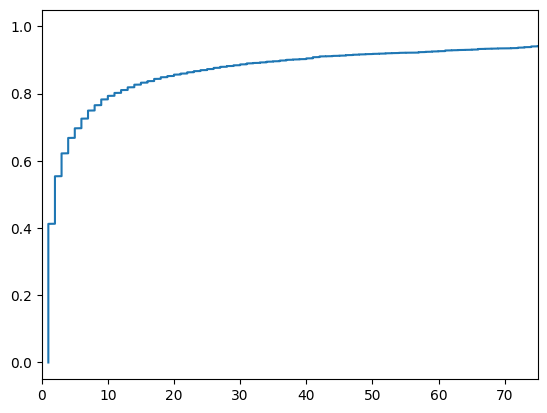

In [3]:
# Count how many uni ids per rhash before validation

pre_val_uni_ct = {k: len(v['uniprot_ids']) for k,v in known_rxns.items()}

pre_val_w_any, n_rxns = ct_any_ids(known_rxns)
print(f"{pre_val_w_any} / {n_rxns} have any uniprot ids")

xcdf_pre_val = sorted([elt for elt in pre_val_uni_ct.values() if elt > 0])
ycdf_pre_val = np.arange(len(xcdf_pre_val)) / len(xcdf_pre_val)

plt.plot(xcdf_pre_val, ycdf_pre_val)
plt.xlim(0,75)
plt.show()

In [4]:
# Assemble rhea reactions
rhea_smarts = pd.read_csv("../data/mapping/rhea-reaction-smiles.tsv", sep='\t', header=None, names=['rhea_id', 'smarts'])
rhea_directions = pd.read_csv("../data/mapping/rhea-directions.tsv", sep='\t')
rhea_smarts.head()

,rhea_id,smarts
0,10001,CCCCC(N)=O.[H]O[H]>>CCCCC(=O)[O-].[H][N+]([H])...
1,10002,CCCCC(=O)[O-].[H][N+]([H])([H])[H]>>CCCCC(N)=O...
2,10005,S=C=NCC1=CC=CC=C1>>N#CSCC1=CC=CC=C1
3,10006,N#CSCC1=CC=CC=C1>>S=C=NCC1=CC=CC=C1
4,10009,*N[C@@H](CS)C(*)=O.*N[C@@H](CS)C(*)=O.*OO>>*N[...


In [5]:
# See what types of rhea ids I got

rhea_ids_from_up = set()
master_ids = set(rhea_directions.loc[:, "RHEA_ID_MASTER"].values)
lr_ids = set(rhea_directions.loc[:, "RHEA_ID_LR"].values)
rl_ids = set(rhea_directions.loc[:, "RHEA_ID_RL"].values)
bi_ids = set(rhea_directions.loc[:, "RHEA_ID_BI"].values)
ids_w_sma = set(rhea_smarts.loc[:, 'rhea_id'].values)
other_ids = set()


for k,v in known_rxns.items():
    for uid in v['uniprot_ids']:
        if uid in jni_up:
            for rid in jni_up[uid]['rhea_ids']:
                rid = int(rid.split(':')[-1])
                rhea_ids_from_up.add(rid)

                if (rid not in master_ids) and (rid not in lr_ids) and (rid not in rl_ids) and (rid not in bi_ids) and (rid not in ids_w_sma):
                    other_ids.add(rid)

print(f"total needed: {len(rhea_ids_from_up)}, master: {len(master_ids)}, LR: {len(lr_ids)}, RL: {len(rl_ids)}, BI: {len(bi_ids)}, Other: {len(other_ids)}")

total needed: 7950, master: 16270, LR: 16270, RL: 16270, BI: 16270, Other: 184


In [6]:
print(len(master_ids & ids_w_sma), len(bi_ids & ids_w_sma), len(ids_w_sma - (lr_ids | rl_ids)))
'''
For all rows in rhea directions
    Check if lr and rl ids in ids with sma
    If both: get sma, 
    elif one: get sma, reverse it
    else continue
    put in tuple, enter in dict under all ids
'''
def smarts_to_sub_smiles(smarts):
    reactants, products = smarts.split(">>")
    reactants = reactants.split('.')
    products = products.split('.')
    return reactants, products

def sub_smiles_to_smarts(reactants, products):
    sma = ".".join(reactants) + '>>' + ".".join(products)
    return sma

def get_rhash(reactants, products):
    reactants_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in reactants]).items())
    products_hash_stoich = list(Counter([get_compound_hash(elt)[0] for elt in products]).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

def get_stoichless_rhash(reactants, products):
    reactants_hash_stoich = list(Counter(set([get_compound_hash(elt)[0] for elt in reactants])).items())
    products_hash_stoich = list(Counter(set([get_compound_hash(elt)[0] for elt in products])).items())
    rhash = get_reaction_hash(reactants_hash_stoich, products_hash_stoich)
    return rhash

# Multiple rhea ids will map to 
# same tuple of reaction info
rhea_id_to_rhashes = {}
rhea_id_to_stoichless_rhashes = {}
rhea_id_to_smarts = {}
for _, row in rhea_directions.iterrows():
    lrid, rlid = row["RHEA_ID_LR"], row["RHEA_ID_RL"]
    if lrid in ids_w_sma and rlid in ids_w_sma:
        lr_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == lrid, 'smarts'].values[0]
        rl_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == rlid, 'smarts'].values[0]
    elif lrid in ids_w_sma:
        lr_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == lrid, 'smarts'].values[0]
        rl_sma = ">>".join([lr_sma.split('>>')[1], lr_sma.split('>>')[0]])
    elif rlid in ids_w_sma:
        rl_sma = rhea_smarts.loc[rhea_smarts['rhea_id'] == rlid, 'smarts'].values[0]
        lr_sma = ">>".join([lr_sma.split('>>')[1], lr_sma.split('>>')[0]])
    else:
        continue

    san_sma = []
    rhashes = []
    stoichless_rhashes = []
    for sma in [lr_sma, rl_sma]:
        reactants, products = smarts_to_sub_smiles(sma)
        reactants = [elt for elt in reactants if elt != '[H+]'] # Remove protons
        products = [elt for elt in products if elt != '[H+]']
        reactants, products = sanitize(reactants, products)
        reactants, products = neutralize(reactants, products)
        sma = ".".join(reactants) + '>>' + ".".join(products)
        rhash = get_rhash(reactants, products)
        stoichless_rhash = get_stoichless_rhash(reactants, products)
        san_sma.append(sma)
        rhashes.append(rhash)
        stoichless_rhashes.append(stoichless_rhash)

        for id in row.to_list():
            rhea_id_to_rhashes[id] = tuple(rhashes)
            rhea_id_to_stoichless_rhashes[id] = tuple(stoichless_rhashes)
            rhea_id_to_smarts[id] = tuple(san_sma)

0 0 0


[01:54:57] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[01:54:57] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[01:54:57] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[01:54:57] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:57] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:54:58] WARNING: not removi

In [7]:
# Are they off by stoich only?

# Re-hash known reactions without stoich
for k, v in known_rxns.items():
    reactants, products = smarts_to_sub_smiles(v['smarts'])
    stoichless_rhash = get_stoichless_rhash(reactants, products)
    v['stoichless_rhash'] = stoichless_rhash
    

[01:58:05] Can't kekulize mol.  Unkekulized atoms: 3 5 6 12
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 3 5 6 12
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 2 4 5 11
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 16 20 23 24 25 26 27 28 30 31
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 8 9 10 12 13 24
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7 8 9 10 12 13 24
[01:58:05] Can't kekulize mol.  Unkekulized atoms: 16 20 23 24 25 26 27 28 30 31
[01:58:06] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:06] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:07] Can't kekulize mol.  Unkekulized atoms: 1 5 6 7 8 9
[01:58:

In [124]:
# Filter known reactions' uniprot ids

'''
Filters
'''
in_uniprot = lambda x : x in jni_up # Whether I found uniprot id in uniprot
has_rxn = lambda x : len(jni_up[x]['rhea_ids']) > 0 # Whether a found uniprot entry had rhea reactions at all

def is_rhash_equivalent(x, putative_rhash, jni_up, rhea_id_to_rhashes):
        '''
        Do any rhea reaction rhashes form up entry match the one from joseph's
        known reactions?
        '''
        rheas = [int(elt.split(":")[1]) for elt in jni_up[x]['rhea_ids']]
        bool_list = [putative_rhash in rhea_id_to_rhashes.get(elt, []) for elt in rheas]
        return any(bool_list)

def is_stoichless_rhash_equivalent(x, putative_rhash, jni_up, rhea_id_to_rhashes):
        '''
        Do any rhea reaction rhashes form up entry match the one from joseph's
        known reactions?
        '''
        rheas = [int(elt.split(":")[1]) for elt in jni_up[x]['rhea_ids']]
        bool_list = [putative_rhash in rhea_id_to_rhashes.get(elt, []) for elt in rheas]
        return any(bool_list)

def filter_known_rxns_uniprot(filter_fcn, known_rxns, jni_up=jni_up,
                                rhea_id_to_rhashes=rhea_id_to_rhashes,
                                rhea_id_to_stoichless_rhashes=rhea_id_to_stoichless_rhashes,
                                rhea_id_to_smarts=rhea_id_to_smarts):
    '''
    Wraparound filter dict to process known rxns entries    
    '''
    temp = deepcopy(known_rxns)
    filtered_known_rxns = {}
    for k,v in tqdm(temp.items(), desc='known rxns'):
        if filter_fcn is is_rhash_equivalent:
            _filter_fcn = lambda x: filter_fcn(x, k, jni_up, rhea_id_to_rhashes) # Pass putative rhash, k and dicts

        elif filter_fcn is is_stoichless_rhash_equivalent:
            _filter_fcn = lambda x: filter_fcn(x, v['stoichless_rhash'], jni_up, rhea_id_to_stoichless_rhashes) # Pass stoichless putative rhash

        elif filter_fcn is is_mcs_similar:
            _filter_fcn = lambda x: filter_fcn(x, v['smarts'], jni_up, rhea_id_to_smarts) # Pass smarts, rhea smarts lookup

        else:
            _filter_fcn = filter_fcn

        ds_uids = list(filter(_filter_fcn, v['uniprot_ids']))
        filtered_known_rxns[k] = v
        filtered_known_rxns[k]['uniprot_ids'] = ds_uids
    return filtered_known_rxns

known_rxns_found_uid = filter_known_rxns_uniprot(in_uniprot, known_rxns)
n_any, n_rxns = ct_any_ids(known_rxns_found_uid)
print(f"{n_any} / {n_rxns} rxns with uniprot ids I found in uniprot")

known_rxns_found_rhea_rxn = filter_known_rxns_uniprot(has_rxn, known_rxns_found_uid)
n_any, n_rxns = ct_any_ids(known_rxns_found_rhea_rxn)
print(f"{n_any} / {n_rxns} rxns with uniprot with reactions")

known_rxns_stoichless_equivalent = filter_known_rxns_uniprot(is_stoichless_rhash_equivalent, known_rxns_found_rhea_rxn)
n_any, n_rxns = ct_any_ids(known_rxns_stoichless_equivalent)
print(f"{n_any} / {n_rxns} rxns with stoichless rhash equivalence")

known_rxns_w_rhash_eq = filter_known_rxns_uniprot(is_rhash_equivalent, known_rxns_found_rhea_rxn)
n_any, n_rxns = ct_any_ids(known_rxns_w_rhash_eq)
print(f"{n_any} / {n_rxns} rxns with uniprot with rhash equivalent rhea reactions")

known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 298759.15it/s]


19568 / 51329 rxns with uniprot ids I found in uniprot


known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 233666.10it/s]


15289 / 51329 rxns with uniprot with reactions


known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 67041.77it/s]


5765 / 51329 rxns with stoichless rhash equivalence


known rxns: 100%|██████████| 51329/51329 [00:00<00:00, 78071.47it/s]

5761 / 51329 rxns with uniprot with rhash equivalent rhea reactions


In [125]:
# Get known rxns w uniprot with rhea rxns but which were
# not matched by rhash
unmatched_by_rhash = {}
for k in known_rxns.keys():
    if known_rxns_found_rhea_rxn[k]['uniprot_ids'] and not known_rxns_w_rhash_eq[k]['uniprot_ids']:
        unmatched_by_rhash[k] = known_rxns_found_rhea_rxn[k]

print(len(unmatched_by_rhash))

# Arrange remaining rhea rxn ids
# under key of known (reaction hash, (rhea_rxn hashes))
side_by_side = defaultdict(list)
rhea_rhashes_to_smarts = defaultdict(set)
for key, kr in unmatched_by_rhash.items():
    for uid in kr['uniprot_ids']:
        for rhea in jni_up[uid]['rhea_ids']:
            rhea = int(rhea.split(":")[1])
            if rhea in rhea_id_to_rhashes:
                rhea_hash = rhea_id_to_rhashes[rhea]
                rhea_smarts = rhea_id_to_smarts[rhea]
                side_by_side[(key, rhea_hash)].append(rhea)
                rhea_rhashes_to_smarts[rhea_hash].add(rhea_smarts[0])
                rhea_rhashes_to_smarts[rhea_hash].add(rhea_smarts[1])
                
# Load mcs similarity scores indexed in same way as side_by_side
with open("../data/mapping/mcs_similarity_known_rhea_rxn_pairs.pkl", 'rb') as f:
    mcs_scores = pickle.load(f)

rhea_rhashes_to_id = defaultdict(list)
for k,v in rhea_id_to_rhashes.items():
    rhea_rhashes_to_id[v].append(k)

9528


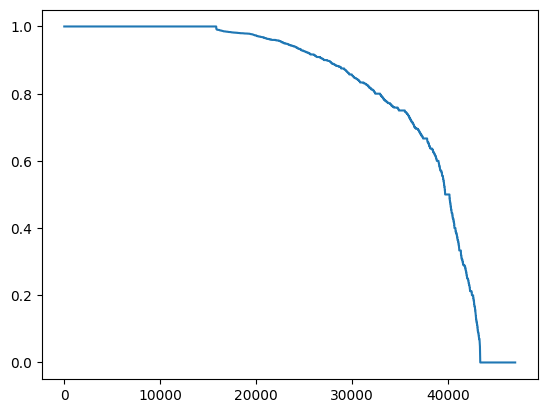

In [27]:
hashes, scores = zip(*sorted(mcs_scores.items(), key=lambda x: x[1], reverse=True))
plt.plot(scores)

In [410]:
i = 0

In [419]:
kr_sma = known_rxns[hashes[i][0]]['smarts']
rhea_sma = list(rhea_rhashes_to_smarts[hashes[i][1]])
print(f"i = {i}")
print(scores[i])
print(kr_sma)
for elt in rhea_sma:
    print(elt)
i+=1

i = 8
1.0
*C(=O)OCC(COP(=O)(O)OCCNC)OC(*)=O.Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O>>*C(=O)OCC(COP(=O)(O)OCCN)OC(*)=O.C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O
Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O.[1*]C(=O)OCC(COP(=O)(O)OCCNC)OC([2*])=O>>C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.[1*]C(=O)OCC(COP(=O)(O)OCCN)OC([2*])=O
C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.[1*]C(=O)OCC(COP(=O)(O)OCCN)OC([2*])=O>>Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O.[1*]C(=O)OCC(COP(=O)(O)OCCNC)OC([2*])=O


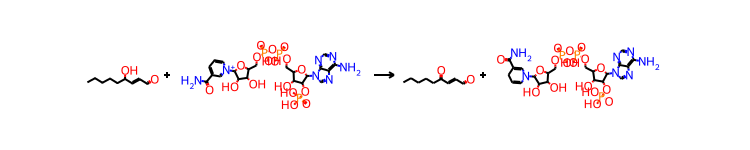

In [393]:
AllChem.ReactionFromSmarts(kr_sma, useSmiles=True)


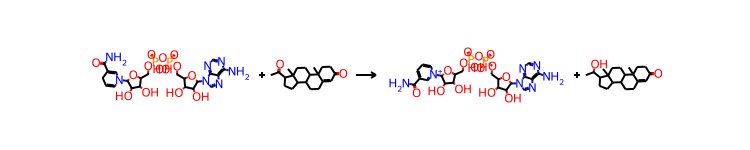

In [394]:
AllChem.ReactionFromSmarts(rhea_sma[0], useSmiles=True)